<a href="https://colab.research.google.com/github/SimoneCallegarin/NLP_project/blob/branch1/SA%20and%20TextGen%20on%20EDOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Environment Setup**

## **Libraries Imports**

In [2]:
%%capture
import pandas as pd
import re
import numpy as np
import random
#from google.colab import files

# Downsampling:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,ShuffleSplit
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform,randint
from xgboost import XGBClassifier
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Preprocessing:
#!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import regexp_replace, lower, trim, size, col, array_except, array, lit, udf, row_number
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pandas.core.common import flatten
import ast

# Interactive table library:
%%capture
!pip install ipyaggrid
import ipyaggrid

# Clustering:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.sql.functions import regexp_replace, split

# Graphs:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Embeddings:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import gensim.downloader as api

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline
fig, ax = plt.subplots(figsize=(14, 5))

A function for printing graphs in a formatted way

In [ ]:
def print_graph(title, xlab, ylab, rotated):
    plt.title(title)
    plt.ylabel(ylab, fontsize=12)
    plt.xlabel(xlab, fontsize=12)
    if rotated:
        plt.xticks(rotation=90)

## **Dataset Download**

In [3]:
csv_path_initial = "https://media.githubusercontent.com/media/SimoneCallegarin/NLP_project/main/Data/EDOS_1M.csv"
csv_path_preprocessed = "https://media.githubusercontent.com/media/SimoneCallegarin/NLP_project/branch1/Data/preprocessed_EDOS.csv"

# **Dataset Import and Cleaning**

We will now import the EDOS dataset and clean it from:
    
- duplicates
- null values

In [ ]:
df = pd.read_csv(csv_path_initial)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2829426 entries, 0 to 2829425
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   dialogue_id       int64  
 1   turn              int64  
 2   uttr              object 
 3   eb+_emot          object 
 4   label_confidence  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 107.9+ MB


In [ ]:
df.head()

dialogue_id  turn                                               uttr  \
0           97     1  You moron ! What fool washes diapers by the we...   
1           97     2                                 You useless fool !   
2           99     1                               How dare you sleep !   
3           99     2                      Up ! Go and clean the house .   
4          100     1                                Clean the kitchen .   

   eb+_emot  label_confidence  
0     angry          0.437522  
1   furious          0.731564  
2   furious          0.605636  
3  prepared          0.650449  
4  prepared          0.742187

In [ ]:
df.duplicated().sum()

0

In [ ]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return None
    else:
        return s

In [ ]:
df['uttr'].apply(lambda s: isEnglish(s)).size  #same size as before, no rows were removed 

2829426

As we can see the dataset was already cleaned since we have no duplicated, null rows or not-ASCII characters (which usually means we are dealing with a multilingual dataset), so we can proceed to the next steps without worries.

--- 
Here instead we load an already preprocessed version of the dataset (in the **Dataset Preprocessing** section). It is made available in the [github repository](https://github.com/SimoneCallegarin/NLP_project/blob/main/Data/preprocessed_EDOS.csv).

In [ ]:
final_df = pd.read_csv(csv_path_preprocessed)

# **Preliminary Analysis**

## **EDA - Exploratory Data Analysis**

Before diving into the training and evaluation of many different NLP models, we will perform the EDA (Exploratory Data Analysis) to have basic but fundamental insights about the data.

In particular we will get:

- basic informations about the dataset
- some descriptive statistics

### **Basic Understanding of the Dataset**

As stated on the dataset website, EDOS contains short phrases (from 3 to 5 utterances), each labeled with an emotion. Let's get a better look at them

In [ ]:
print([x for x in df['uttr'][0:5]])

['You moron ! What fool washes diapers by the well !', 'You useless fool !', 'How dare you sleep !', 'Up ! Go and clean the house .', 'Clean the kitchen .']


Let's now check all the possible values of the emotion type, which will be our target in case of sentiment analysis

In [ ]:
emotions = df['eb+_emot'].unique()
print(emotions)

['angry' 'furious' 'prepared' 'acknowledging' 'trusting' 'confident'
 'hopeful' 'caring' 'sentimental' 'anticipating' 'wishing' 'surprised'
 'ashamed' 'questioning' 'sad' 'nostalgic' 'devastated' 'terrified'
 'embarrassed' 'lonely' 'encouraging' 'suggesting' 'content' 'afraid'
 'impressed' 'agreeing' 'apprehensive' 'proud' 'annoyed' 'anxious'
 'grateful' 'excited' 'neutral' 'faithful' 'guilty' 'consoling'
 'disgusted' 'disappointed' 'jealous' 'joyful' 'sympathizing']


With all these possible emotions to predict, it's very probable that we will have to deal with unbalanced classes

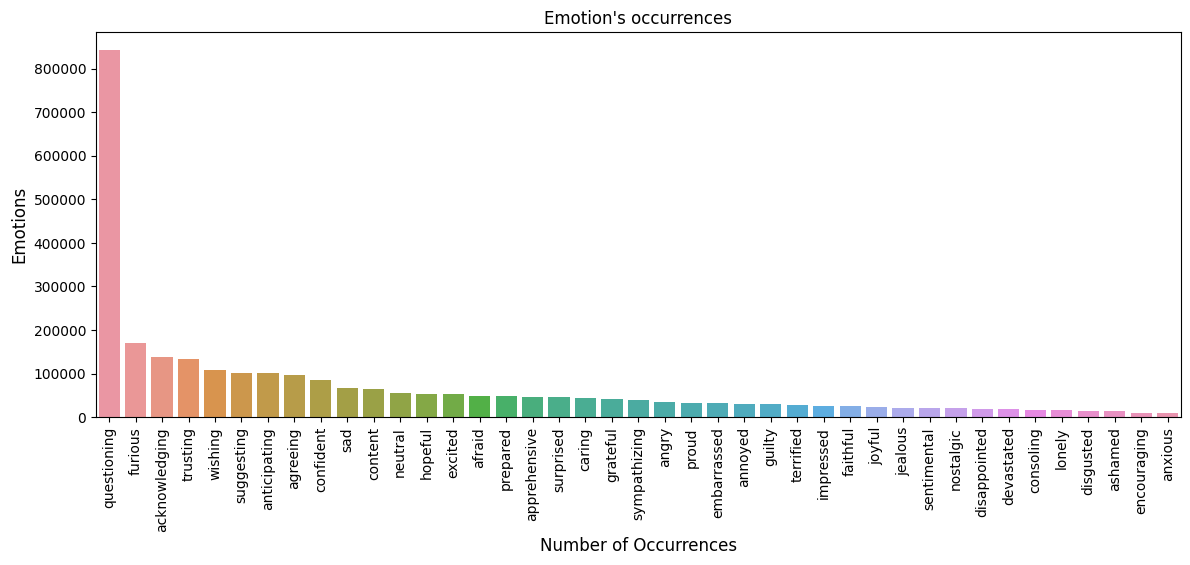

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.countplot(data=df, x='eb+_emot', order=df['eb+_emot'].value_counts().index, ax=ax)
print_graph('Emotion\'s occurrences', 'Number of Occurrences', 'Emotions', True)

In [ ]:
df['eb+_emot'].value_counts()[:5]

questioning      841556
furious          169917
acknowledging    138165
trusting         134197
wishing          108668
Name: eb+_emot, dtype: int64

As we can see, we have quite an unbalancing here with the 'questioning' texts being over 800k while all the others stay under 200k.

We will have to deal with it in the next phases when we will have to train models on this dataset

### **Descriptive Statistics**

We will use some text visualization techniques for better and instant insights about:

- text lengths distribution
- word number distribution

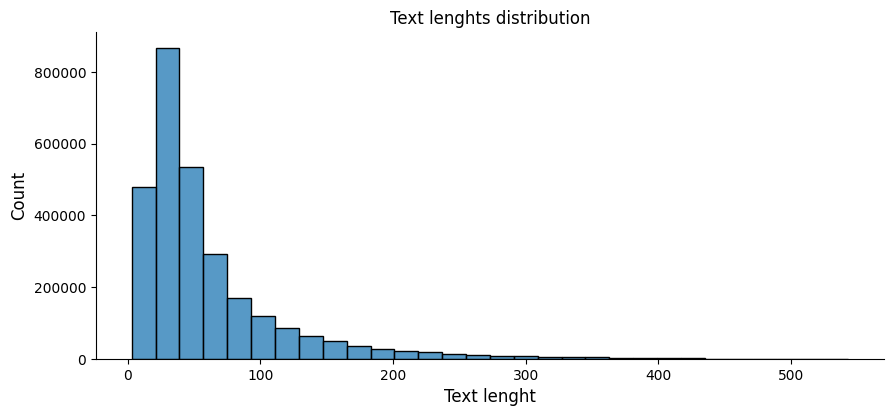

In [ ]:
sns.displot(df['uttr'].str.len(), kde = False, bins = 30, height=4, aspect=9/4)
print_graph("Text lenghts distribution", "Text lenght", "Count", False)

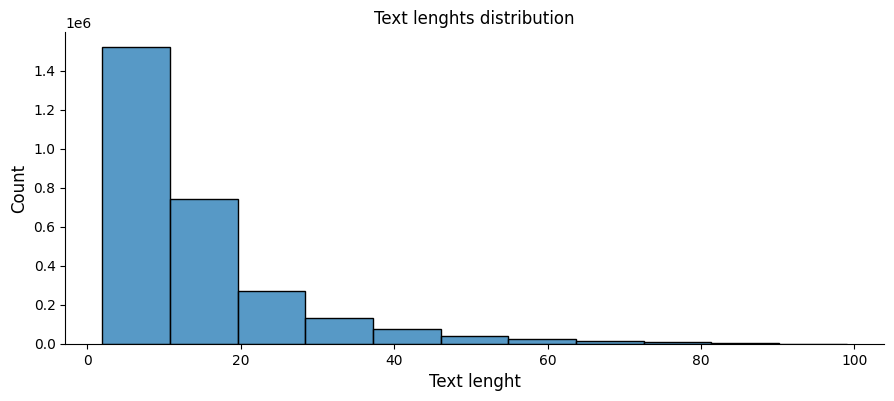

In [ ]:
sns.displot(df['uttr'].str.split().map(lambda x: len(x)), kde = False, bins = 11, height=4, aspect=9/4)
print_graph("Text lenghts distribution", "Text lenght", "Count", False)

It's clear that most texts' vocabulary size stays under 20 words, with the most being between 2 and 10.

But we can also see we have pretty long texts too so let's have a look at one of them

In [ ]:
df[(df['uttr'].str.len() > 300)]['uttr'].iloc[0]

"Glenn , why don 't you tell us about the top looks ? Kris , we love the ram look of your makeup , and some of the smaller sculptural details were very impressive . It was a very comprehensive makeup . Wayne , your use of proportion was excellent this week . We were also blown away by how much killer sculpting you pulled off . Who is the winner of this challenge ?"

## **Dataset Preprocessing**

### **Downsampling**

We have to decide how much data to have for each class. Since we don't want to have repeating data points, we will keep the number of samples corresponding to the ones we have in the least populated class. So the number of discarded points of a certain class will be proportional to the original size of that class.

In [ ]:
ds = df[['eb+_emot','uttr']]

In [ ]:
n_samples = ds['eb+_emot'].value_counts()[-1]
print("Number of samples:",n_samples)
n_classes = ds['eb+_emot'].unique().size
print("Number of classes:",n_classes)

Number of samples: 8578
Number of classes: 41


In [ ]:
downsample_ds = pd.DataFrame(columns=ds.columns)
for label in ds['eb+_emot'].unique():
    partial_ds = resample(ds[ds['eb+_emot']==label],random_state=42,replace=True,n_samples=n_samples)
    downsample_ds = pd.concat([downsample_ds,partial_ds])

In [ ]:
downsample_ds['eb+_emot'].value_counts()

angry            8578
suggesting       8578
afraid           8578
impressed        8578
agreeing         8578
apprehensive     8578
proud            8578
annoyed          8578
anxious          8578
grateful         8578
excited          8578
neutral          8578
faithful         8578
guilty           8578
consoling        8578
disgusted        8578
disappointed     8578
jealous          8578
joyful           8578
content          8578
encouraging      8578
furious          8578
lonely           8578
prepared         8578
acknowledging    8578
trusting         8578
confident        8578
hopeful          8578
caring           8578
sentimental      8578
anticipating     8578
wishing          8578
surprised        8578
ashamed          8578
questioning      8578
sad              8578
nostalgic        8578
devastated       8578
terrified        8578
embarrassed      8578
sympathizing     8578
Name: eb+_emot, dtype: int64

### **Spark Preprocessing**

We used *pyspark* to scale the workload to any size by running it distributed across multiple nodes.

In [ ]:
# Create a SparkSession
spark = SparkSession.builder.appName('Preprocess').getOrCreate()

In [ ]:
# Convert Pandas DataFrame to Spark DataFrame
df_spark = spark.createDataFrame(downsample_ds)

# Show the first few rows of the Spark DataFrame
df_spark.show(truncate=False)

+--------+-----------------------------------------------------------------------------------------------------------------------------------------+
|eb+_emot|uttr                                                                                                                                     |
+--------+-----------------------------------------------------------------------------------------------------------------------------------------+
|angry   |It 's fired up by powerful negative emotions , like fear , rage , anger , and hate .                                                     |
|angry   |Hell no !                                                                                                                                |
|angry   |Yuki Yuki won 't get up Yuki !                                                                                                           |
|angry   |Jesus Christ , they 're shooting at us !                                                        

In [ ]:
# Define a function to expand contractions
def expand_contractions(text):
    contractions = {
        "ain 't": "am not", "aren 't": "are not", "can 't": "cannot", "can 't 've": "cannot have", "'cause": "because", "could 've": "could have", "couldn 't": "could not", "couldn 't 've": "could not have", "didn 't": "did not", "doesn 't": "does not", "don 't": "do not", "hadn 't": "had not", "hadn 't've": "had not have", "hasn 't": "has not", "haven 't": "have not", "he 'd": "he would", "he 'd 've": "he would have", "he 'll": "he will", "he 'll 've": "he will have", "he 's": "he is", "how 'd": "how did", "how 'd 'y": "how do you", "how 'll": "how will", "how 's": "how is", "i 'd": "i would", "i 'd've": "i would have", "i 'll": "i will", "i 'll've": "i will have", "i 'm": "i am", "i 've": "i have", "isn 't": "is not", "it 'd": "it would", "it 'd've": "it would have", "it 'll": "it will", "it 'll've": "it will have", "it 's": "it is", "let 's": "let us", "ma 'am": "madam", "mayn 't": "may not", "might 've": "might have", "mightn 't": "might not", "mightn 't 've": "might not have", "must 've": "must have", "mustn 't": "must not", "mustn 't 've": "must not have", "needn 't": "need not", "needn 't 've": "need not have", "o 'clock": "of the clock", "oughtn 't": "ought not", "oughtn 't 've": "ought not have", "shan 't": "shall not", "sha 'n 't": "shall not", "shan 't 've": "shall not have", "she 'd": "she would", "she 'd 've": "she would have", "she 'll": "she will", "she 'll 've": "she will have", "she 's": "she is", "should 've": "should have", "shouldn 't": "should not", "shouldn 't 've": "should not have", "so 've": "so have", "so 's": "so is", "that 'd": "that would", "that 'd 've": "that would have", "that 's": "that is", "there 'd": "there would", "there 'd've": "there would have", "there 's": "there is", "they 'd": "they would", "they 'd 've": "they would have", "they 'll": "they will", "they 'll 've": "they will have", "they 're": "they are", "they 've": "they have", "to 've": "to have", "wasn 't": "was not", "we 'd": "we would", "we 'd 've": "we would have", "we 'll": "we will", "we 'll 've": "we will have", "we 're": "we are", "we 've": "we have", "weren 't": "were not", "what 'll": "what will", "what 'll 've": "what will have", "what 're": "what are", "what 's": "what is", "what 've": "what have", "when 's": "when is", "when 've": "when have", "where 'd": "where did", "where 's": "where is", "where 've": "where have", "who 'll": "who will", "who 'll've": "who will have", "who 's": "who is", "who 've": "who have", "why 's": "why is", "why 've": "why have", "will 've": "will have", "won 't": "will not", "won 't've": "will not have", "would 've": "would have", "wouldn 't": "would not", "wouldn 't've": "would not have", "y 'all": "you all", "y 'all 'd": "you all would", "y 'all 'd've": "you all would have", "y 'all 're": "you all are", "y 'all 've": "you all have", "you 'd": "you would", "you 'd 've": "you would have", "you 'll": "you will", "you 'll 've": "you will have", "you 're": "you are", "you 've": "you have"
    }
    for contraction, replacement in contractions.items():
        text = text.replace(contraction, replacement)
    return text

Apply the first transformation to the text of the dataset:
* Lowercase the texts of the utterances (the 'uttr' column)
* Expand contractions
* Remove punctuation
* Remove numbers
* Remove leading and trailing spaces of each sentence
* Replace all multiple spaces between each word (generated in previous steps) with a single space

In [ ]:
# Lowercase utterances words
cleaned_df = df_spark.select(lower('uttr').alias('cleaned_text'), 'eb+_emot')

# Expand contractions 
cleaned_df = cleaned_df.withColumn('cleaned_text',udf(expand_contractions, StringType())('cleaned_text'))

# Remove punctuation and numbers 
cleaned_df = cleaned_df.withColumn('cleaned_text', regexp_replace('cleaned_text', '[^a-zA-Z\s]+', ''))

# Remove leading and trailing spaces
cleaned_df = cleaned_df.withColumn('cleaned_text', trim(cleaned_df['cleaned_text']))

# Replace multiple spaces with single spaces
cleaned_df = cleaned_df.withColumn('cleaned_text', regexp_replace('cleaned_text', '\s+', ' '))

Tokenize the text that was preprocessed before remove the stop words from the tokens, and remove rows left without token.

In [ ]:
# Tokenize text 
tokenizer = Tokenizer(inputCol='cleaned_text', outputCol='tokens')

# Filter out stop words
stop_words = StopWordsRemover.loadDefaultStopWords('english')
stopwords_remover = StopWordsRemover(inputCol='tokens', outputCol='filtered_tokens', stopWords=stop_words)

pipeline = Pipeline(stages=[tokenizer, stopwords_remover])

# Execute the pipeline and select the two interesting rows
cleaned_df = pipeline.fit(cleaned_df).transform(cleaned_df).select('eb+_emot','filtered_tokens')

# Filter utterances without tokens
cleaned_df = cleaned_df.filter(size(col('filtered_tokens')) != 0)

For completeness we printed some rows for each emotion of the preprocessed dataframe obtained.

In [ ]:
# define a window specification to partition the rows by eb+_emot and order them by the default order
window_spec = Window.partitionBy("eb+_emot").orderBy("filtered_tokens")

# assign a row number to each row within each group of eb+_emot values
df_with_row_number = cleaned_df.withColumn("row_number", row_number().over(window_spec))

# filter the rows with row numbers less than or equal to 2
print_df = df_with_row_number.filter("row_number <= 2")

# print the resulting DataFrame
print_df.show(truncate=False)

+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|eb+_emot    |filtered_tokens                                                                                                                                          |row_number|
+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|afraid      |[aah, latches, afraid]                                                                                                                                   |1         |
|afraid      |[abby, somebody, tried, kill, lab, safe]                                                                                                                 |2         |
|agreeing    |[aah]                                                                                 

### **Store the Preprocessed Dataset**

Convert the spark dataframe that has been preprocessed and download it.
We proceeded to upload it in the github repository.

In [ ]:
final_df = cleaned_df.toPandas()

In [ ]:
final_df.to_csv('preprocessed_EDOS.csv', index=False ,encoding = 'utf-8') 
files.download('preprocessed_EDOS.csv')

### **Preprocessing Results**

This is the result of the preprocessing phase. It is made available in the [github repository](https://github.com/SimoneCallegarin/NLP_project/blob/main/Data/preprocessed_EDOS.csv).

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349920 entries, 0 to 349919
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   eb+_emot         349920 non-null  object
 1   filtered_tokens  349920 non-null  object
dtypes: object(2)
memory usage: 5.3+ MB


Showing the resulting dataframe thorugh an interactive table library.

In [ ]:
grid_options = {
    'enable_filter': True,
    'enable_sorting': True,
    'enable_col_resize': True,
    'enable_range_selection': True,
    'enable_selection': True,
    'row_selection': 'multiple',
    'filter': True,
    'sort': True,
    'columnDefs': [{'headerName': col, 'field': col} for col in final_df.columns]
}

grid = ipyaggrid.Grid(grid_data=final_df, grid_options=grid_options, quick_filter=True)
grid

Grid(columns_fit='size_to_fit', compress_data=True, export_mode='disabled', height='350px', menu={'buttons': […

## **Clustering**

In this section we will apply some clustering techniques to check what groups can be found and if those corresponds, even partially, to our known classes.

In [ ]:
emotions = final_df['eb+_emot'].unique()
print(emotions)

['angry' 'furious' 'prepared' 'acknowledging' 'trusting' 'confident'
 'hopeful' 'caring' 'sentimental' 'anticipating' 'wishing' 'surprised'
 'ashamed' 'questioning' 'sad' 'nostalgic' 'devastated' 'terrified'
 'embarrassed' 'lonely' 'encouraging' 'suggesting' 'content' 'afraid'
 'impressed' 'agreeing' 'apprehensive' 'proud' 'annoyed' 'anxious'
 'grateful' 'excited' 'neutral' 'faithful' 'guilty' 'consoling'
 'disgusted' 'disappointed' 'jealous' 'joyful' 'sympathizing']


In [ ]:
n_topics = len(emotions)

In [ ]:
min_doc_freq = 200
max_doc_freq = 0.6

### **Vectorization with TF-IDF**

Before diving into clustering, we will have to preprocess our dataset. In particular we will have to vectorize our texts and to do that we will use TF-IDF.

In [ ]:
X = final_df['filtered_tokens']
y = final_df['eb+_emot']

We will remove numbers since they don't represent any meaningful information in our semantical context and they only enlarge TF-IDF vectors slowing down training and preprocessing steps.

We will remove numbers and stopwords from the corpus, plus words appearing in less than 10 documents or in more than the 80% of the collection (to remove corpus-specific stopwords).

In [ ]:
tfidf_vec = TfidfVectorizer(strip_accents='unicode',
                            stop_words='english',
                            lowercase=True,
                            min_df=min_doc_freq,
                            max_df=max_doc_freq
                           )

In [ ]:
Xf = tfidf_vec.fit_transform(X)

In [ ]:
tfidf_vec.get_feature_names_out().size

1291

In [ ]:
print('Vocabulary: ')
print(tfidf_vec.get_feature_names_out())

Vocabulary: 
['able' 'absolutely' 'accept' ... 'yesterday' 'york' 'young']


### **Clustering with K-Means**

In [ ]:
kmeans = KMeans(n_clusters=n_topics,
                max_iter=100,
                n_init=2,
                verbose=False,
                random_state=2307)
kmeans.fit(Xf)

KMeans(max_iter=100, n_clusters=41, n_init=2, random_state=2307, verbose=False)

In [ ]:
print("Top terms per cluster:")
vocab = tfidf_vec.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]    
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i} :\t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0 :	['work', 'know', 'good', 'hard', 'like', 'got', 'going', 'time', 'let', 'think']
Cluster 1 :	['stand', 'know', 'anymore', 'let', 'come', 'man', 'chance', 'right', 'like', 'ready']
Cluster 2 :	['maybe', 'know', 'think', 'like', 'time', 'come', 'little', 'right', 'look', 'good']
Cluster 3 :	['know', 'like', 'good', 'think', 'let', 'look', 'time', 'oh', 'going', 'man']
Cluster 4 :	['suppose', 'know', 'yes', 'think', 'time', 'want', 'come', 'like', 'going', 'way']
Cluster 5 :	['stay', 'away', 'want', 'right', 'let', 'going', 'long', 'home', 'come', 'know']
Cluster 6 :	['okay', 'right', 'let', 'gonna', 'later', 'yeah', 'got', 'come', 'sorry', 'going']
Cluster 7 :	['got', 'right', 'know', 'like', 'let', 'come', 'think', 'look', 'good', 'time']
Cluster 8 :	['leave', 'let', 'message', 'want', 'come', 'going', 'away', 'stop', 'right', 'like']
Cluster 9 :	['thank', 'god', 'oh', 'coming', 'sir', 'good', 'yes', 'right', 'know', 'thanks']
Cluster 10 :	['love', 'kn

Results don't look very promising. We can see that many words repeat in different clusters like 'come' or 'know' and this suggests that KMeans algorithm didn't succeed in splitting datapoints into clear, distinct clusters.
But to have a better idea of how KMeans performed in our task, let's compute extrisinc evaluation metrics.

In [ ]:
print('Extrinsic evaluation measures:')
print("Homogeneity:", str(metrics.homogeneity_score(y, kmeans.labels_)))
print("Completeness:", str(metrics.completeness_score(y, kmeans.labels_)))
print("V-measure:", str(metrics.v_measure_score(y, kmeans.labels_)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(y, kmeans.labels_)))

Extrinsic evaluation measures:
Homogeneity: 0.07405007202345051
Completeness: 0.14901219100030413
V-measure: 0.0989352777683386
Adjusted Rand-Index: 0.003668571582862629


As expected, results are not very accurate. This could be caused by many different characteristics of our dataset like for example non-spherical clusters or unequal cluster size or density. We probably need a more complex clustering algorithm

### **Clustering with LDA**

KMeans algorithm tries to associate each data point to a single cluster and in our case this may have been one of the reasons of its bad performance. Let's try to generate again the clusters by using Latent Dirichlet Allocation, which will associate each datapoints to a variety of topics (clusters) which could be useful in more complex datasets like ours.

In [ ]:
%%capture
!pip install pyspark

In [ ]:
# Create a SparkSession
spark_lda = SparkSession.builder.appName('LDA_clustering').config("spark.executor.memory", "8g").config("spark.executor.instances", "4").config("spark.hadoop.fs.defaultFS", "hdfs://namenode:8020").getOrCreate()

In [ ]:
# Convert Pandas DataFrame to Spark DataFrame
df_spark_lda = spark_lda.createDataFrame(final_df)

# Show the first few rows of the Spark DataFrame
df_spark_lda.show(truncate=False)

+--------+----------------------------------------------------------------------------------------------------------------------------------+
|eb+_emot|filtered_tokens                                                                                                                   |
+--------+----------------------------------------------------------------------------------------------------------------------------------+
|angry   |['fired', 'powerful', 'negative', 'emotions', 'like', 'fear', 'rage', 'anger', 'hate']                                            |
|angry   |['hell']                                                                                                                          |
|angry   |['yuki', 'yuki', 'get', 'yuki']                                                                                                   |
|angry   |['jesus', 'christ', 'shooting', 'us']                                                                                             |
|angry

In [ ]:
# Remove brackets and quotes from filtered_tokens column
df_spark_lda = df_spark_lda.withColumn("filtered_tokens", regexp_replace(col("filtered_tokens"), "[\[\]\']", ""))

# Split filtered_tokens column on commas to create an array of strings
df_spark_lda = df_spark_lda.withColumn("filtered_tokens", split(col("filtered_tokens"), ", "))

# Show the first few rows of the Spark DataFrame
df_spark_lda.show(truncate=False)

+--------+--------------------------------------------------------------------------------------------------------+
|eb+_emot|filtered_tokens                                                                                         |
+--------+--------------------------------------------------------------------------------------------------------+
|angry   |[fired, powerful, negative, emotions, like, fear, rage, anger, hate]                                    |
|angry   |[hell]                                                                                                  |
|angry   |[yuki, yuki, get, yuki]                                                                                 |
|angry   |[jesus, christ, shooting, us]                                                                           |
|angry   |[damn, alexander, shoot, hell, help]                                                                    |
|angry   |[neighbors, called, complaint, said, firing, gun, morning]    

In [ ]:
# Compute the term frequency of the words
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="raw_features", minDF=min_doc_freq, maxDF=max_doc_freq)
vectorizerModel  = vectorizer.fit(df_spark_lda)
df_vectorized = vectorizerModel.transform(df_spark_lda)

In [ ]:
# Compute the IDF (inverse document frequency) of the words
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(df_vectorized)
df_features = idfModel.transform(df_vectorized)

In [ ]:
df_features.cache()

lda = LDA(k=n_topics, maxIter=100, optimizer="online", featuresCol="features")

df_features.unpersist()

DataFrame[eb+_emot: string, filtered_tokens: array<string>, raw_features: vector, features: vector]

In [ ]:
lda = LDA(k=n_topics, maxIter=100, featuresCol="features")
ldaModel = lda.fit(df_features)

In [ ]:
topics = ldaModel.describeTopics(maxTermsPerTopic=10)
vocabulary = vectorizerModel.vocabulary
for row in topics.rdd.collect():
    print("Topic: {}".format(row.topic))
    for i in range(len(row.termIndices)):
        print("{}: {}".format(vocabulary[row.termIndices[i]], row.termWeights[i]))
    print("\n")

Topic: 0
look: 0.1902432960052329
son: 0.07544292464978457
hard: 0.05274173464723573
trying: 0.049626951111844536
almost: 0.03926726765493812
poor: 0.030478407786536647
different: 0.030467616964148545
bitch: 0.028718528082418062
perhaps: 0.027431589895234594
ll: 0.026768990251081454


Topic: 1
hope: 0.10520111266527069
help: 0.09867402750852969
keep: 0.08563333157420171
thanks: 0.07378235119961679
boy: 0.05916698720146838
idea: 0.04171728141499918
true: 0.03859423719510561
hate: 0.03697316325427872
problem: 0.0353597384009081
asked: 0.03081866549134695


Topic: 2
better: 0.1261407048180717
real: 0.07115698823792432
late: 0.07068681736270417
listen: 0.06795149234725345
says: 0.052758179506744024
anymore: 0.048416698802483504
read: 0.039583022245735004
loved: 0.03763269681595914
light: 0.03526753331604041
return: 0.03493175942564305


Topic: 3
think: 0.198979703223112
oh: 0.17554169296099886
meet: 0.047197082248974925
hold: 0.04413278324510275
hands: 0.03800924361552948
part: 0.035425265

In [ ]:
import pyLDAvis.gensim as gensimvis
vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

## **Embeddings**

### **Word2Vec**

Let's prepare the dataset for the tokenization under a Word2Vec model. 
First we need to remove the non-alphabetic characters. 
We proceed by trasforming everything into lowercase, by removing punctuaction, and by removing sentences that are only 1 word long, since they won't be useful for training the model.

In [4]:
from pandas.core.common import flatten

df = pd.read_csv(csv_path_initial)
sentences = df['uttr']
sentences = list(flatten(sentences))
sentences[:20]

['You moron ! What fool washes diapers by the well !',
 'You useless fool !',
 'How dare you sleep !',
 'Up ! Go and clean the house .',
 'Clean the kitchen .',
 "I cleaned the kitchen , ma 'am .",
 'Your name means to trust . It also means truth . And endurance . Or it could be god .',
 "You were given a great name . You 'd better live up to it .",
 "I 'll go home in the spring once the snow melts .",
 "Listen . No matter how tough it gets I wouldn 't bring shame to you and your dad . I promise I won 't .",
 'Your medicine . Open your mouth .',
 'Granny ...',
 "Don 't spill it .",
 'Granny !',
 'Oshin .',
 "Brandon said he 's headed down to Galway .",
 "Craking , Galway , it 's the same thing . He 's really heading down there ...",
 'Hi there , Welcome to the Stockroom .',
 "I don 't really work here . I 've never even been to a store like this .",
 "Don 't get me wrong . I 'm not a prude . I like sex ."]

In [5]:
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in sentences]
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

Loading of the model.

In [6]:
from gensim.models.word2vec import Word2Vec

w2v_model = Word2Vec(sentences=tokenized_sentences,
                     window=8,
                     vector_size=50)

In [7]:
len(w2v_model.wv)  #number of learned vectors

59722

Let's evaluate if the model has learned a significant embedding

In [4]:
terms = ["medicine","wrong", "never"]

In [8]:
for term in terms:
    print("Term: {t}".format(t=term))
    print(w2v_model.wv.most_similar(term))

Term: medicine
[('medication', 0.7784976363182068), ('prescription', 0.7479158639907837), ('medicines', 0.7353808283805847), ('herbs', 0.7255712151527405), ('food', 0.6972001791000366), ('antibiotics', 0.6948564648628235), ('bath', 0.6912020444869995), ('treatment', 0.685947060585022), ('kidney', 0.6629589200019836), ('pills', 0.6566216349601746)]
Term: wrong
[('happening', 0.7000006437301636), ('happened', 0.6251766681671143), ('matter', 0.6049478650093079), ('interfering', 0.5708127021789551), ('bothering', 0.567085325717926), ('troubling', 0.5520431995391846), ('serious', 0.5424646735191345), ('obsessed', 0.5356438159942627), ('angry', 0.5313842296600342), ('weird', 0.5310375690460205)]
Term: never
[('ever', 0.7962556481361389), ('always', 0.6779649257659912), ('if', 0.6603551506996155), ('before', 0.6599072217941284), ('once', 0.626842200756073), ('i', 0.6144284605979919), ('when', 0.5959470868110657), ('but', 0.5926728844642639), ('though', 0.5696454644203186), ('already', 0.56687

Visualization of the representation space with TSNE

In [11]:
from sklearn.manifold import TSNE

sample = random.sample(list(w2v_model.wv.key_to_index), 500)
print(sample)

word_vectors = w2v_model.wv[sample]

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)
x, y, z = np.transpose(tsne_embedding)

['sac', 'monitoring', 'tthe', 'brogan', 'chatterjee', 'landline', 'bret', 'backside', 'salaries', 'imprisonment', 'hardin', 'funnily', 'ballerina', 'voilá', 'pearson', 'nipsu', 'anny', 'lunch', 'grunting', 'kes', 'kimberley', 'recognisable', 'angelo', 'damp', 'required', 'luger', 'dedalus', 'dara', 'pocketbook', 'cordillera', 'headlamp', 'anda', 'thanos', 'whitaker', 'gringoire', 'bizzy', 'catrin', 'mood', 'orihime', 'stared', 'wilde', 'staircase', 'footnote', 'vladislav', 'hovv', 'gibberish', 'log', 'sergeant', 'oska', 'reggio', 'denham', 'songkran', '2010', 'stalls', 'seduction', 'designers', 'primera', 'norte', 'livened', 'gunfire', 'vio', 'bankbook', 'sharpened', 'fucken', 'trolls', 'krusty', 'colombo', 'royale', 'shears', 'shigeyuki', 'arirang', 'mooney', 'nein', 'ul', 'pollo', 'xv', 'harvests', 'couse', 'bauer', 'lesions', 'simpering', 'dialects', 'flyboy', 'merryweather', 'shitless', 'cuteness', 'mvp', 'gandil', 'tarsus', 'hortense', 'whatthe', 'keung', 'objectivity', 'tipper', 

In [13]:
import plotly.express as px

fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

Now let's repeat the same analysis with the Spark-preprocessed dataset.


In [18]:
df = pd.read_csv(csv_path_preprocessed)
sentences = df['filtered_tokens']
tokenized_sentences = sentences.apply(ast.literal_eval)

In [19]:
w2v_model_preprocessing = Word2Vec(sentences=tokenized_sentences,
                     window=8,
                     vector_size=50)

In [20]:
len(w2v_model_preprocessing.wv)  #less than half of the previous model

22347

In [21]:
for term in terms:
    print("Term: {t}".format(t=term))
    print(w2v_model_preprocessing.wv.most_similar(term))   #not so performing

Term: medicine
[('coat', 0.7890298366546631), ('pill', 0.7879699468612671), ('dough', 0.7790007591247559), ('plate', 0.7638892531394958), ('shampoo', 0.75490802526474), ('inconsiderate', 0.7520648241043091), ('meds', 0.7502426505088806), ('risks', 0.7496783137321472), ('bandage', 0.7485405802726746), ('backseat', 0.7481127977371216)]
Term: wrong
[('happened', 0.7086515426635742), ('happening', 0.7030606269836426), ('happen', 0.6783460974693298), ('else', 0.6743075847625732), ('serious', 0.6333675384521484), ('happens', 0.6265120506286621), ('blame', 0.6031826138496399), ('weird', 0.5996603965759277), ('except', 0.5837724804878235), ('terrible', 0.5690361857414246)]
Term: never
[('ever', 0.7172060608863831), ('knew', 0.6268485188484192), ('wondered', 0.5683382153511047), ('without', 0.5537112355232239), ('yet', 0.5352032780647278), ('thought', 0.5351524949073792), ('finally', 0.531467616558075), ('loved', 0.524813711643219), ('felt', 0.5116083025932312), ('ve', 0.5086502432823181)]


In [22]:
sample = random.sample(list(w2v_model_preprocessing.wv.key_to_index), 500)
print(sample)
word_vectors = w2v_model_preprocessing.wv[sample]

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)
x, y, z = np.transpose(tsne_embedding)

['bu', 'none', 'curtis', 'transferring', 'rendered', 'cylinders', 'liz', 'reputation', 'darkness', 'actions', 'chubby', 'foreigners', 'duds', 'bungalow', 'brooks', 'yourfather', 'buggy', 'riddled', 'auto', 'indicated', 'gobetween', 'watchman', 'yuh', 'seeping', 'two', 'wildly', 'erupt', 'revision', 'circumstances', 'openminded', 'gen', 'arrests', 'princess', 'recon', 'hymn', 'influenced', 'quid', 'camps', 'flies', 'seating', 'interferes', 'santa', 'goodnight', 'revenge', 'bummer', 'exercise', 'lyon', 'zo', 'brainiac', 'russian', 'buy', 'sheba', 'sizzling', 'victim', 'reyes', 'temperance', 'persian', 'try', 'squires', 'swap', 'bob', 'visible', 'hillard', 'co', 'saturated', 'loads', 'garcia', 'mailed', 'brave', 'spruce', 'compositions', 'virtually', 'respond', 'suffer', 'implosion', 'recycling', 'president', 'seances', 'luis', 'monitoring', 'fascination', 'drat', 'headache', 'debut', 'outlaw', 'miyuki', 'scenes', 'graduates', 'visits', 'dixie', 'sulk', 'makeup', 'consumer', 'hendrix', 'p

In [23]:
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

### **GloVe**

Since we are dealing with short sentences and sentiment analysis, we will use the GloVe model trained on Twitter dataset.


In [24]:
import gensim.downloader as api
model_twitter = api.load("glove-twitter-50")

[==================================================] 100.0% 199.5/199.5MB downloaded


In [25]:
for term in terms:
    print("Term: {t}".format(t=term))
    print(model_twitter.most_similar(term))  #significant embedding, seems slightly stronger than  word2vec

Term: medicine
[('medication', 0.8416867256164551), ('therapy', 0.8170652389526367), ('meds', 0.7926548719406128), ('health', 0.7851440906524658), ('brain', 0.7601990699768066), ('pills', 0.7591844797134399), ('treatment', 0.738800585269928), ('doctors', 0.7377061247825623), ('drug', 0.7347596883773804), ('coffee', 0.7316195368766785)]
Term: wrong
[('either', 0.9382398724555969), ('exactly', 0.9320201277732849), ('reason', 0.9299482703208923), ('saying', 0.9250219464302063), ('meant', 0.923551082611084), ('anything', 0.919384777545929), ('that', 0.9190050959587097), ('mean', 0.9172501564025879), ('think', 0.9169749021530151), ('something', 0.9169007539749146)]
Term: never
[("n't", 0.9409230947494507), ('remember', 0.9262502789497375), ('ever', 0.9245465397834778), ('always', 0.9208585023880005), ('know', 0.9152477979660034), ('not', 0.9128117561340332), ('forget', 0.9113688468933105), ('could', 0.9102745056152344), ('think', 0.9096735715866089), ('even', 0.9096729159355164)]


### **FastText**

In [ ]:
!pip install fasttext

!wget http://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gzip -d cc.en.300.bin.gz

In [5]:
import fasttext

ft_model = fasttext.load_model('./cc.en.300.bin')

In [6]:
for term in terms:
    print("Term: {t}".format(t=term))
    print(ft_model.get_nearest_neighbors(term))  #too large vocabulary and typos influences the embedding

Term: medicine
[(0.7423003315925598, 'medicine.The'), (0.7390528321266174, 'medecine'), (0.7086049318313599, 'medicine.'), (0.699951171875, 'medicine-'), (0.6978245973587036, 'medicine.This'), (0.6861584186553955, 'medicines'), (0.6817944645881653, 'medicine.In'), (0.6783857345581055, 'medicine.It'), (0.6643877029418945, 'medicne'), (0.6600144505500793, 'medicine-based')]
Term: wrong
[(0.7719298005104065, 'worng'), (0.6939500570297241, 'wrong.But'), (0.6801682710647583, 'WRONG'), (0.6761754155158997, 'wrong.And'), (0.6712054014205933, 'wrong-'), (0.6709033250808716, 'wrong.Now'), (0.6692678928375244, 'wronger'), (0.6660706996917725, 'wrong.So'), (0.6634148359298706, 'wrong.However'), (0.6517934799194336, 'wrong.That')]
Term: never
[(0.738477885723114, 'ever'), (0.6982719898223877, 'NEVER'), (0.6741805076599121, 'always'), (0.6599420309066772, 'rarely'), (0.6598708033561707, 'have'), (0.6588050723075867, 'seldom'), (0.6551389694213867, 'Never'), (0.6492555141448975, 'hadn'), (0.63038146

Let's build a FastText model and train it on our dataset  

In [10]:
from pandas.core.common import flatten

df = pd.read_csv(csv_path_initial)
sentences = df['uttr']
sentences = list(flatten(sentences))

with open('./sentences.txt', 'w') as f:
    f.write('\n'.join(sentences))

In [12]:
ft_skip_model = fasttext.train_unsupervised('./sentences.txt', model='skipgram', minCount=5, dim=50, ws=8)

KeyboardInterrupt: ignored

In [ ]:
ft_cbow_model = fasttext.train_unsupervised(csv_path_initial, model='cbow', minCount=5, dim=50, ws=8)

## **Indexing for Keyword Search**

In [ ]:
#TODO

# **Sentiment Analysis**

In this first part we will try many different Machine Learning models and compare the performance between TF-IDF and WordEmbedding vectorization approach.
We have three main challenges in this part:

- class imbalance
- dataset size
- hyperparameter tuning

We can't handle the whole dataset with the available resources, we will downsample it, keeping only a small portion. Since downsampling is often also used to resolve class imbalance problems,we will take advantage of that to mantain the same amount of data for each class of our problem.

For what regards hyperparameter tuning, we will use GridSearch with 5-Fold Cross Validation or Bayesian Optimization with HyperOpt Library.

For what regards evaluation, we will simply split the dataset between train set and test set (20%), avoiding validation set.
When we will train deep learning models instead we will split between train and validation set to use learning rate schedulers, early stopping and other tools to improve performance of the model based on validation loss.

## **Training and Evaluation with TF-IDF Vectorization**

In [ ]:
X = final_ds['uttr']
y = final_ds['eb+_emot']

### **Train, Test Splitting**

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

### **Vectorization with TF-IDF**

As before (Clustering section) we will preprocess and vectorize the corpus but this time we will also vectorize the labels.

In [ ]:
def preprocess(t):
    return re.sub('[0-9]','',t).lower()

In [ ]:
tfidf_vec = TfidfVectorizer(strip_accents='unicode',
                            stop_words='english',
                            preprocessor=preprocess,
                            lowercase=True,
                            min_df=200,
                            max_df=0.70
                           )

In [ ]:
train_x = tfidf_vec.fit_transform(train_x)
test_x = tfidf_vec.transform(test_x)

In [ ]:
train_x.shape

(281358, 1092)

We now need to encode labels. To do that we can use Label Encoding, which associates a integer number to each class,so in our case each one of our emotions will be mapped to a number between 0 and 40.
In alternative we also can use One-Hot Encoding, which transforms each class to a sparse one-hot encoded vector.

Label Encoding introduces a problem because the model may derive a ordinal correlation of some sort due to the fact that labels are mathematically related (i.e: if 0 is cat, 1 is dog and 2 is tiger, the model could derive that average between cat and tiger is dog whic is obviously wrong).

In multi-class sentiment analysis both encodings are interesting but after some tests we found out that label encoding works best, capturing the intuitive ordinal relationship between the emotions (i.e: angry is 0, furious is 1 so furious > angry).

In [ ]:
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.transform(test_y)

### **Linear Classifier**

#### **Multinomial Logistic Regression**

Since the original Logistic Regression model was made with binary classification problems in mind, it doesn't natively support multi classification problems. However, SKLearn implementation supports multiclass problem, so we are going to use Multinomial Logistic Regression, which is a single classifier, instead of  OneVSRest or OneVSOne approaches.

In [ ]:
params = {'n_jobs':[-1],
          'multi_class':['multinomial'],
          'solver':['saga'],
          'C':[1,0.1,0.01],
          'max_iter':[100],
          'penalty':['l1','l2']}

In [ ]:
log_reg = LogisticRegression()

In [ ]:
gs = GridSearchCV(log_reg,params,cv=2,scoring='accuracy')

In [ ]:
gs.fit(train_x,train_y)

GridSearchCV(cv=2, estimator=LogisticRegression(),
             param_grid={'C': [1, 0.1, 0.01], 'max_iter': [100],
                         'multi_class': ['multinomial'], 'n_jobs': [-1],
                         'penalty': ['l1', 'l2'], 'solver': ['saga']},
             scoring='accuracy')

In [ ]:
print(f"The best parameters are {gs.best_params_}")

The best parameters are {'C': 1, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': -1, 'penalty': 'l2', 'solver': 'saga'}


In [ ]:
y_pred = gs.predict(test_x)

In [ ]:
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.31      0.21      0.25      1716
           1       0.57      0.47      0.51      1716
           2       0.36      0.40      0.38      1716
           3       0.52      0.38      0.44      1716
           4       0.30      0.28      0.29      1715
           5       0.38      0.40      0.39      1716
           6       0.49      0.45      0.47      1715
           7       0.36      0.38      0.37      1716
           8       0.40      0.27      0.32      1715
           9       0.34      0.36      0.35      1715
          10       0.26      0.24      0.25      1716
          11       0.49      0.39      0.44      1716
          12       0.44      0.51      0.47      1715
          13       0.42      0.41      0.41      1715
          14       0.46      0.43      0.44      1716
          15       0.54      0.43      0.48      1715
          16       0.71      0.48      0.58      1716
          17       0.51    

### **Random Forest Classifier**

In [ ]:
search_space = {
    'bootstrap': True,
    'max_features': 'sqrt',
    'min_samples_leaf': hp.quniform('min_samples_leaf',1, 5,1),
    'min_samples_split': hp.quniform('min_samples_split',1, 4,1),
    'n_estimators': 100
}

In [ ]:
def hyperparameter_tuning(space):
    random_forest = RandomForestClassifier(bootstrap=space['bootstrap'],
                                          max_depth=None,
                                          max_features=space['max_features'],
                                          min_samples_leaf=int(space['min_samples_leaf']),
                                          min_samples_split=int(space['min_samples_split']))

    random_forest.fit(train_x, train_y)

    y_pred = random_forest.predict(test_x)
    accuracy = accuracy_score(test_y, y_pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': random_forest}

In [ ]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print (best)

In [ ]:
random_forest = RandomForestClassifier(max_depth=None,
                                       min_samples_leaf=1,
                                       min_samples_split=2,
                                       bootstrap=True,
                                       max_features='sqrt',
                                       n_estimators=100)
random_forest.fit(train_x,train_y)
y_pred = random_forest.predict(test_x)
print(classification_report(test_y,y_pred))
print(accuracy_score(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.30      0.24      0.27      1716
           1       0.59      0.53      0.55      1716
           2       0.33      0.41      0.37      1716
           3       0.53      0.43      0.47      1716
           4       0.37      0.30      0.33      1715
           5       0.39      0.39      0.39      1716
           6       0.71      0.65      0.68      1715
           7       0.40      0.47      0.44      1716
           8       0.60      0.43      0.50      1715
           9       0.37      0.38      0.38      1715
          10       0.24      0.22      0.23      1716
          11       0.56      0.50      0.53      1716
          12       0.45      0.52      0.48      1715
          13       0.51      0.47      0.49      1715
          14       0.57      0.52      0.54      1716
          15       0.62      0.49      0.54      1715
          16       0.77      0.53      0.63      1716
          17       0.59    

### **XGB Classifier**

XGBoost is an ensemble algorithm, in particular a boosting one. It has the reputation of being one of the most effective ML algorithm for both regression and classification and it's often used in Kaggle Competitions with good results. Thank to GPU acceleration we can train a XGB instance in few minutes so we will tune its hyperparameters using Bayesian Optimization which differs from GridSearch and RandomSearch for being an informed search algorithm, which uses previous iterations to decide where to search next in the search space. For this reason a single iteration is usually longer than the ones on uninformed algorithms like grid search but it usually converges faster to good solutions.

In [ ]:
search_space={'max_depth': hp.quniform("max_depth", 8, 12, 1),
              'gamma': 0.5,
              'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
              'reg_lambda' : hp.uniform('reg_lambda', 0,1),
              'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
              'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
              'learning_rate':hp.uniform('learning_rate',0.01,0.2),
              'n_estimators': 350 }

In [ ]:
def hyperparameter_tuning(space):
    xgb = XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'],tree_method='gpu_hist',gpu_id=0,objective='multi:softmax',
                         learning_rate=space['learning_rate'])   
    xgb.fit(train_x, train_y)

    y_pred = xgb.predict(test_x)
    accuracy = accuracy_score(test_y, y_pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': xgb}

In [ ]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print (best)

In [ ]:
xgb = XGBClassifier(n_estimators=350,
                    max_depth=8,
                    gamma=0.5,
                    verbosity = 0,
                    tree_method='gpu_hist', 
                    gpu_id=0,
                    objective='multi:softmax')  #0.43
xgb.fit(train_x, train_y)

y_pred = xgb.predict(test_x)
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.30      0.25      0.27      1716
           1       0.58      0.50      0.54      1716
           2       0.34      0.42      0.37      1716
           3       0.51      0.40      0.45      1716
           4       0.35      0.29      0.32      1715
           5       0.40      0.41      0.41      1716
           6       0.62      0.53      0.57      1715
           7       0.41      0.44      0.42      1716
           8       0.51      0.31      0.38      1715
           9       0.37      0.37      0.37      1715
          10       0.25      0.23      0.24      1716
          11       0.52      0.43      0.47      1716
          12       0.43      0.55      0.48      1715
          13       0.48      0.43      0.45      1715
          14       0.50      0.46      0.48      1716
          15       0.59      0.44      0.51      1715
          16       0.72      0.50      0.59      1716
          17       0.56    

### **Neural Networks**

Devo ancora finirlo.

In [ ]:
from tensorflow.data import Dataset,experimental
from tensorflow.keras.layers import Input,Dense,LSTM,TextVectorization,Reshape,Flatten,Embedding
from tensorflow.keras.models import Sequential
from tensorflow import expand_dims,string,strings
from tensorflow.keras.metrics import Accuracy
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow import initializers,convert_to_tensor

In [ ]:
X = final_ds['uttr']
y = final_ds['eb+_emot']

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)

In [ ]:
vocab = tfidf_vec.get_feature_names_out() #explain why we need vocab

In [ ]:
ds = Dataset.from_tensor_slices((X,y))  #advantages of tf.dataset?

In [ ]:
ds_cardinality = experimental.cardinality(ds)  #what is this?
ds = ds.shuffle(seed=42,buffer_size=ds_cardinality)
train_set = ds.skip(ds_cardinality // 5)
test_set = ds.take(ds_cardinality // 5)

In [ ]:
test_cardinality = experimental.cardinality(test_set)
val_set = test_set.take(test_cardinality // 5)
test_set = test_set.skip(test_cardinality // 5)

In [ ]:
train_set = train_set.batch(32)
val_set = val_set.batch(32)
test_set = test_set.batch(32)

In [ ]:
def preprocess(t):
    return strings.lower(strings.regex_replace(t,"[^A-Za-z ]+",""))

In [ ]:
textvec = TextVectorization(max_tokens=vocab.size+1,
                            standardize=preprocess,
                            output_mode="tf_idf",
                            vocabulary=vocab,
                            idf_weights=tfidf_vec.idf_
                           )  #why are we doing this again?

In [ ]:
textvec("mr")  #do example demonstration

<tf.Tensor: shape=(1093,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [ ]:
model = Sequential()
model.add(Input(shape=(),dtype=string))
model.add(textvec)
model.add(Reshape((vocab.size+1,1)))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(256,return_sequences=False))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(41,activation="softmax"))

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics="accuracy")

In [ ]:
lr_sched = ReduceLROnPlateau(monitor='val_loss',verbose=3,patience=5)
mdl_check = ModelCheckpoint("model_ckpt",verbose=3,monitor='val_loss',save_best_only=True,mode='max')
early_stop = EarlyStopping(monitor='val_loss',patience=11,verbose=3)

In [ ]:
model.fit(train_set,epochs=30,validation_data=val_set,callbacks=[lr_sched,mdl_check,early_stop],batch_size=32)

Epoch 1/30
8793/8793 [==============================] - ETA: 0s - loss: 3.7030 - accuracy: 0.0308
Epoch 1: val_loss improved from -inf to 3.71356, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 557s 63ms/step - loss: 3.7030 - accuracy: 0.0308 - val_loss: 3.7136 - val_accuracy: 0.0254 - lr: 0.0010
Epoch 2/30
4028/8793 [============>.................] - ETA: 4:48 - loss: 3.7138 - accuracy: 0.0241

KeyboardInterrupt: 

In [ ]:
model.fit(train_set,epochs=30,validation_data=val_set,callbacks=[lr_sched,mdl_check,early_stop],batch_size=32)

## **Training and Evaluation with Word2Vec Embeddings**

In this section, we will train all the models again by using Word2Vec Embeddings and compare the results.An embedding maps a word to a semantic vector. We call those semantic vector because they preserve semantic information related to the word they represent.In particular, words with a semantic relationship correspond to vectors that are close together in the vector space. They usually perform better than TF-IDF,BoW and similar. The main reasons are two:

- dense vectors vs sparse vectors: Embeddings are much smaller than sparse encoding methods since they produce dense vectors so training and inference are usually faster.

- semantic information is preserved: Sparse encoding methods only use frequency to encode words, while with embeddings, the semantic meaning of the input is kept and can be used to boost the performance of the model.

To produce our Word2Vec embeddings we will use SpaCy, a powerful open-source NLP library, which is broadly used in the industry due to its fast performance. In particular, we will perform Sentence Encoding, which produces a vector for each utterance in the dataset, by averaging the embeddings for each single word of the sentence. This approach is usually preferred in text-classification where we focus on the whole sentence meaning, while word-level embeddings performs better where more granular understanding is required like in PoS or Entity Recognition.

In [ ]:
X = final_ds['uttr']
y = final_ds['eb+_emot']

### **Sentence Encoding with SpaCy**

In [ ]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 4.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import spacy
from numpy import vstack,save,load

In [ ]:
nlp = spacy.load('en_core_web_lg')

embedding_dim = len(nlp('The').vector)

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

For each utterance in the dataset, we compute its sentence encoding. Given the amount of data at our disposition this operation will require some time so we will save the resulting vectors to be able to load them at any point without computing all the embeddings again.

In [ ]:
train_x = [nlp(text).vector for text in train_x] #we get a list of vectors, where each vector is the sentence encoding
train_x=vstack(train_x)

In [ ]:
test_x = [nlp(text).vector for text in test_x] #we get a list of vectors, where each vector is the sentence encoding
test_x=vstack(test_x)

In [ ]:
test_x.shape

(68451, 300)

In [ ]:
train_x.shape

(273802, 300)

As we can see we obtained a list of sentence encodings, one for each entry in the dataset. Each encoding is composed by 300 float32.

In [ ]:
save("sent_encodings/train.npy", train_x, allow_pickle=True, fix_imports=True)
save("sent_encodings/test.npy", test_x, allow_pickle=True, fix_imports=True)

In [ ]:
train_x = load("sent_encodings/train.npy",allow_pickle=True)
test_x = load("sent_encodings/test.npy",allow_pickle=True)

In [ ]:
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.transform(test_y)

### **Linear Classifier**

#### **Multinomial Logistic Regression**

Since sentence encodings are dense vectors, they will take much more time than TF-IDF sparse compressed vectors. For this reason, even in case of a slightly improvement in the predictions, TF-IDF is probably the preferable approach.

Given the resources and the amount of data, we won't repeat the hyperparameter tuning, but instead, use the optimal parameters found in the TF-IDF Vectorization section.

In [ ]:
log_reg = LogisticRegression(n_jobs=-1,
                            multi_class='multinomial',
                            solver='saga',
                            C=1,
                            penalty='l2')

In [ ]:
log_reg.fit(train_x,train_y)

In [ ]:
y_pred = log_reg.predict(test_x)

In [ ]:
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.36      0.36      0.36      1716
           1       0.47      0.41      0.44      1716
           2       0.41      0.41      0.41      1716
           3       0.50      0.42      0.46      1716
           4       0.39      0.40      0.39      1715
           5       0.47      0.49      0.48      1716
           6       0.52      0.57      0.54      1715
           7       0.44      0.47      0.46      1716
           8       0.38      0.35      0.37      1715
           9       0.44      0.43      0.44      1715
          10       0.38      0.38      0.38      1716
          11       0.59      0.55      0.57      1716
          12       0.54      0.55      0.54      1715
          13       0.50      0.46      0.48      1715
          14       0.37      0.37      0.37      1716
          15       0.59      0.55      0.57      1715
          16       0.48      0.43      0.46      1716
          17       0.56    

### **Random Forest Classifier**

In [ ]:
random_forest = RandomForestClassifier(max_depth=None,
                                       min_samples_leaf=1,
                                       min_samples_split=2,
                                       bootstrap=True,
                                       max_features='sqrt',
                                       n_estimators=100,
                                       n_jobs=-1)
random_forest.fit(train_x,train_y)
y_pred = random_forest.predict(test_x)
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.35      0.37      0.36      1716
           1       0.35      0.24      0.29      1716
           2       0.37      0.37      0.37      1716
           3       0.53      0.40      0.46      1716
           4       0.37      0.34      0.35      1715
           5       0.34      0.35      0.34      1716
           6       0.62      0.67      0.65      1715
           7       0.29      0.51      0.37      1716
           8       0.54      0.48      0.51      1715
           9       0.34      0.38      0.36      1715
          10       0.33      0.26      0.29      1716
          11       0.63      0.62      0.62      1716
          12       0.44      0.37      0.40      1715
          13       0.63      0.45      0.52      1715
          14       0.41      0.44      0.43      1716
          15       0.54      0.56      0.55      1715
          16       0.48      0.41      0.44      1716
          17       0.67    

### **XGB Classifier**

In [ ]:
xgb = XGBClassifier(n_estimators=350,
                    max_depth=8,
                    gamma=0.5,
                    verbosity = 0,
                    tree_method='gpu_hist', 
                    gpu_id=0,
                    objective='multi:softmax')  #0.43
xgb.fit(train_x, train_y)

y_pred = xgb.predict(test_x)
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.42      0.43      0.42      1716
           1       0.45      0.36      0.40      1716
           2       0.41      0.42      0.41      1716
           3       0.54      0.46      0.50      1716
           4       0.45      0.44      0.45      1715
           5       0.44      0.46      0.45      1716
           6       0.70      0.73      0.72      1715
           7       0.43      0.51      0.47      1716
           8       0.56      0.54      0.55      1715
           9       0.44      0.46      0.45      1715
          10       0.39      0.35      0.37      1716
          11       0.70      0.67      0.68      1716
          12       0.55      0.50      0.53      1715
          13       0.61      0.54      0.57      1715
          14       0.49      0.51      0.50      1716
          15       0.64      0.64      0.64      1715
          16       0.54      0.50      0.52      1716
          17       0.71    

### **Neural Networks**

In [ ]:
from tensorflow.data import Dataset,experimental
from tensorflow.keras.layers import Input,Dense,LSTM,TextVectorization,Reshape,Flatten,Embedding,Dropout,Bidirectional
from tensorflow.keras.models import Sequential,Model
from tensorflow import expand_dims,string,strings
from tensorflow.keras.metrics import Accuracy
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow import initializers,convert_to_tensor
from tensorflow.keras.optimizers import Adam

#### **Artificial Neural Network**

In [ ]:
train_set = Dataset.from_tensor_slices((train_x,train_y))  #advantages of tf.dataset?
test_set = Dataset.from_tensor_slices((test_x,test_y))

In [ ]:
test_cardinality = experimental.cardinality(test_set)
val_set = test_set.take(test_cardinality // 5)
test_set = test_set.skip(test_cardinality // 5)

In [ ]:
train_set = train_set.shuffle(buffer_size=experimental.cardinality(train_set)).batch(32)
val_set = val_set.shuffle(buffer_size=experimental.cardinality(val_set)).batch(32)
test_set = test_set.shuffle(buffer_size = experimental.cardinality(test_set)).batch(32)

In [ ]:
embedding_dim = nlp('The').vector.size

Since we are only starting out, let's try a very simple model, made of two Dense layers plus the output layer that normalizes the logits from the 2nd layer using the softmax activation function.

In [ ]:
model = Sequential()
model.add(Dense(64,input_dim=embedding_dim,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(41,activation="softmax"))

In [ ]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics="accuracy")

In [ ]:
lr_sched = ReduceLROnPlateau(mode='max',monitor='val_accuracy',verbose=3,patience=5,factor=0.1)
mdl_check = ModelCheckpoint("model_ckpt",verbose=3,monitor='val_accuracy',save_best_only=True,mode='max')
early_stop = EarlyStopping(monitor='val_accuracy',patience=11,verbose=3)

In [ ]:
model.fit(train_set,epochs=60,validation_data=val_set,callbacks=[lr_sched,mdl_check,early_stop],batch_size=32)

Epoch 1/60
8536/8557 [============================>.] - ETA: 0s - loss: 2.3981 - accuracy: 0.3495
Epoch 1: val_accuracy improved from -inf to 0.38999, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets
8557/8557 [==============================] - 21s 2ms/step - loss: 2.3976 - accuracy: 0.3496 - val_loss: 2.2042 - val_accuracy: 0.3900 - lr: 0.0010
Epoch 2/60
8531/8557 [============================>.] - ETA: 0s - loss: 2.1551 - accuracy: 0.4025
Epoch 2: val_accuracy improved from 0.38999 to 0.41147, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets
8557/8557 [==============================] - 18s 2ms/step - loss: 2.1550 - accuracy: 0.4025 - val_loss: 2.1230 - val_accuracy: 0.4115 - lr: 0.0010
Epoch 3/60
8538/8557 [============================>.] - ETA: 0s - loss: 2.1029 - accuracy: 0.4145
Epoch 3: val_accuracy improved from 0.41147 to 0.41782, saving model to model_ckpt
INFO:tensorflow:Assets written to: model_ckpt/assets
8557/85

In [ ]:
model.evaluate(test_set)

1759/1759 [==============================] - 3s 2ms/step - loss: 1.7415 - accuracy: 0.5037


[1.7414615154266357, 0.5037140846252441]

#### **LSTM Neural Network**

Let's try to add three LSTM (Long Short Term Memory) layers, to see if we can outperform the XGBoost algorithm. We also noticed a slight overfitting in the last epochs, so let's introduce Dropout to see if we can reduce it.

In [ ]:
dropout_rate = 0.3

In [ ]:
train_x = train_x.reshape(-1,1,embedding_dim)
test_x = test_x.reshape(-1,1,embedding_dim)

In [ ]:
train_x.shape

(281358, 1, 300)

In [ ]:
train_set = Dataset.from_tensor_slices((train_x,train_y))  #advantages of tf.dataset?
test_set = Dataset.from_tensor_slices((test_x,test_y))

In [ ]:
test_cardinality = experimental.cardinality(test_set)
val_set = test_set.take(test_cardinality // 5)
test_set = test_set.skip(test_cardinality // 5)

In [ ]:
train_set = train_set.batch(32)
val_set = val_set.batch(32)
test_set = test_set.batch(32)

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(96,return_sequences=True,input_shape=(1,embedding_dim))))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(96,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(96,return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(64,activation="relu"))
model.add(Dense(41,activation="softmax"))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss="sparse_categorical_crossentropy",metrics="accuracy")

In [ ]:
lr_sched = ReduceLROnPlateau(mode='max',monitor='val_accuracy',verbose=3,patience=5,factor=0.1)
mdl_check = ModelCheckpoint("model_ckpt",verbose=3,monitor='val_accuracy',save_best_only=True,mode='max')
early_stop = EarlyStopping(monitor='val_accuracy',patience=11,verbose=3)

In [ ]:
model.fit(train_set,epochs=90,validation_data=val_set,callbacks=[lr_sched,mdl_check,early_stop],batch_size=64)

Epoch 1/90
8791/8793 [============================>.] - ETA: 0s - loss: 2.8906 - accuracy: 0.2100
Epoch 1: val_accuracy improved from -inf to 0.31184, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 195s 21ms/step - loss: 2.8907 - accuracy: 0.2100 - val_loss: 2.4726 - val_accuracy: 0.3118 - lr: 0.0010
Epoch 2/90
8792/8793 [============================>.] - ETA: 0s - loss: 2.4760 - accuracy: 0.3137
Epoch 2: val_accuracy improved from 0.31184 to 0.37276, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 188s 21ms/step - loss: 2.4760 - accuracy: 0.3137 - val_loss: 2.2536 - val_accuracy: 0.3728 - lr: 0.0010
Epoch 3/90
8791/8793 [============================>.] - ETA: 0s - loss: 2.3401 - accuracy: 0.3495
Epoch 3: val_accuracy improved from 0.37276 to 0.39146, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 188s 21ms/step - loss: 2.3401 - accuracy: 0.3495 - val_loss: 2.1501 - val_accuracy: 0.3915 - lr: 0.0010
Epoch 4/90
8791/8793 [============================>.] - ETA: 0s - loss: 2.2656 - accuracy: 0.3679
Epoch 4: val_accuracy improved from 0.39146 to 0.40916, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 193s 22ms/step - loss: 2.2657 - accuracy: 0.3678 - val_loss: 2.1031 - val_accuracy: 0.4092 - lr: 0.0010
Epoch 5/90
8791/8793 [============================>.] - ETA: 0s - loss: 2.2129 - accuracy: 0.3824
Epoch 5: val_accuracy improved from 0.40916 to 0.42152, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 187s 21ms/step - loss: 2.2130 - accuracy: 0.3824 - val_loss: 2.0568 - val_accuracy: 0.4215 - lr: 0.0010
Epoch 6/90
8791/8793 [============================>.] - ETA: 0s - loss: 2.1775 - accuracy: 0.3923
Epoch 6: val_accuracy improved from 0.42152 to 0.43396, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 189s 22ms/step - loss: 2.1775 - accuracy: 0.3923 - val_loss: 2.0161 - val_accuracy: 0.4340 - lr: 0.0010
Epoch 7/90
8792/8793 [============================>.] - ETA: 0s - loss: 2.1450 - accuracy: 0.4001
Epoch 7: val_accuracy improved from 0.43396 to 0.44377, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 189s 22ms/step - loss: 2.1450 - accuracy: 0.4001 - val_loss: 1.9752 - val_accuracy: 0.4438 - lr: 0.0010
Epoch 8/90
8790/8793 [============================>.] - ETA: 0s - loss: 2.1236 - accuracy: 0.4053
Epoch 8: val_accuracy did not improve from 0.44377
8793/8793 [==============================] - 146s 17ms/step - loss: 2.1236 - accuracy: 0.4053 - val_loss: 1.9875 - val_accuracy: 0.4387 - lr: 0.0010
Epoch 9/90
8793/8793 [==============================] - ETA: 0s - loss: 2.1024 - accuracy: 0.4112
Epoch 9: val_accuracy improved from 0.44377 to 0.45003, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 189s 22ms/step - loss: 2.1024 - accuracy: 0.4112 - val_loss: 1.9550 - val_accuracy: 0.4500 - lr: 0.0010
Epoch 10/90
8790/8793 [============================>.] - ETA: 0s - loss: 2.0882 - accuracy: 0.4151
Epoch 10: val_accuracy improved from 0.45003 to 0.45564, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 178s 20ms/step - loss: 2.0882 - accuracy: 0.4151 - val_loss: 1.9204 - val_accuracy: 0.4556 - lr: 0.0010
Epoch 11/90
8791/8793 [============================>.] - ETA: 0s - loss: 2.0733 - accuracy: 0.4189
Epoch 11: val_accuracy did not improve from 0.45564
8793/8793 [==============================] - 142s 16ms/step - loss: 2.0734 - accuracy: 0.4189 - val_loss: 1.9280 - val_accuracy: 0.4519 - lr: 0.0010
Epoch 12/90
8793/8793 [==============================] - ETA: 0s - loss: 2.0622 - accuracy: 0.4218
Epoch 12: val_accuracy did not improve from 0.45564
8793/8793 [==============================] - 146s 17ms/step - loss: 2.0622 - accuracy: 0.4218 - val_loss: 1.9232 - val_accuracy: 0.4519 - lr: 0.0010
Epoch 13/90
8791/8793 [============================>.] - ETA: 0s - loss: 2.0515 - accuracy: 0.4243
Epoch 13: val_accuracy improved from 0.45564 to 0.45870, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 184s 21ms/step - loss: 2.0515 - accuracy: 0.4243 - val_loss: 1.9114 - val_accuracy: 0.4587 - lr: 0.0010
Epoch 14/90
8792/8793 [============================>.] - ETA: 0s - loss: 2.0407 - accuracy: 0.4277
Epoch 14: val_accuracy improved from 0.45870 to 0.46098, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 185s 21ms/step - loss: 2.0407 - accuracy: 0.4277 - val_loss: 1.8978 - val_accuracy: 0.4610 - lr: 0.0010
Epoch 15/90
8793/8793 [==============================] - ETA: 0s - loss: 2.0316 - accuracy: 0.4299
Epoch 15: val_accuracy did not improve from 0.46098
8793/8793 [==============================] - 141s 16ms/step - loss: 2.0316 - accuracy: 0.4299 - val_loss: 1.8920 - val_accuracy: 0.4608 - lr: 0.0010
Epoch 16/90
8792/8793 [============================>.] - ETA: 0s - loss: 2.0234 - accuracy: 0.4327
Epoch 16: val_accuracy improved from 0.46098 to 0.46517, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 184s 21ms/step - loss: 2.0234 - accuracy: 0.4327 - val_loss: 1.8968 - val_accuracy: 0.4652 - lr: 0.0010
Epoch 17/90
8792/8793 [============================>.] - ETA: 0s - loss: 2.0156 - accuracy: 0.4345
Epoch 17: val_accuracy improved from 0.46517 to 0.46751, saving model to model_ckpt


INFO:tensorflow:Assets written to: model_ckpt/assets


INFO:tensorflow:Assets written to: model_ckpt/assets


8793/8793 [==============================] - 187s 21ms/step - loss: 2.0156 - accuracy: 0.4345 - val_loss: 1.8743 - val_accuracy: 0.4675 - lr: 0.0010
Epoch 18/90
5933/8793 [===================>..........] - ETA: 47s - loss: 2.0059 - accuracy: 0.4375

In [ ]:
model.evaluate(test_set)

1759/1759 [==============================] - 10s 5ms/step - loss: 1.6015 - accuracy: 0.5322


[1.6014758348464966, 0.5321651697158813]

## **Training and Evaluation with BERT**

In [ ]:
from transformers import RobertaTokenizerFast,AutoModelForSequenceClassification,Trainer,TrainingArguments
from datasets import load_dataset,Dataset

In [ ]:
le = LabelEncoder()
final_ds['eb+_emot'] = le.fit_transform(final_ds['eb+_emot'])

In [ ]:
hf_ds = Dataset.from_pandas(final_ds)

In [ ]:
hf_ds = hf_ds.remove_columns(column_names="__index_level_0__")

In [ ]:
hf_ds = hf_ds.rename_column(original_column_name="eb+_emot",new_column_name="label")
hf_ds = hf_ds.rename_column(original_column_name="uttr",new_column_name="text")

In [ ]:
hf_ds

Dataset({
    features: ['label', 'text'],
    num_rows: 351698
})

### **Fine-Tuning RoBERTa**

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
roberta = AutoModelForSequenceClassification.from_pretrained("roberta-base",num_labels=41)

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
tokenized_ds = hf_ds.map(preprocess_function, batched=True)

  0%|          | 0/352 [00:00<?, ?ba/s]

In [ ]:
tokenized_ds = tokenized_ds.train_test_split(test_size=0.2,seed=42)

In [ ]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 281358
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 70340
    })
})

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    report_to="none",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True
)

PyTorch: setting up devices


In [ ]:
from datasets import load_metric
metric = load_metric('accuracy')
        
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=roberta,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 281358
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 87925


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 70340
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-17585
Configuration saved in ./results/checkpoint-17585/config.json
Model weights saved in ./results/checkpoint-17585/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-17585/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-17585/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 70340
  

TrainOutput(global_step=87925, training_loss=0.38442389125135223, metrics={'train_runtime': 13209.6043, 'train_samples_per_second': 106.498, 'train_steps_per_second': 6.656, 'total_flos': 4.220834683837072e+16, 'train_loss': 0.38442389125135223, 'epoch': 5.0})

In [ ]:
eval_results = trainer.evaluate(tokenized_ds["test"])

In [ ]:
eval_results

{'eval_loss': 0.580172061920166,
 'eval_accuracy': 0.8785328404890532,
 'eval_runtime': 163.7556,
 'eval_samples_per_second': 429.542,
 'eval_steps_per_second': 26.851,
 'epoch': 5.0}

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Evaluate the model on the test set
result = trainer.predict(tokenized_ds["test"])

In [ ]:
result

PredictionOutput(predictions=array([[-1.1831387 ,  0.10929107, -0.4741153 , ...,  0.608458  ,
        -1.4905188 , -1.5276226 ],
       [-0.85533285, -0.8956785 , -1.9371343 , ..., -0.81844646,
        -0.6451516 ,  0.86993563],
       [ 0.12884603,  1.1935543 ,  1.197596  , ...,  0.03442258,
         0.65176153, -1.0433989 ],
       ...,
       [-0.43972147, -0.5978154 , -0.34759954, ..., -0.08108875,
        -1.8778236 ,  9.218188  ],
       [-0.43303275, -1.3863074 ,  0.12827879, ..., -1.4810247 ,
        -2.1462173 ,  0.33990866],
       [-1.6028577 ,  0.65824276, -1.4681305 , ..., -0.16034953,
         0.27502066, -0.63914484]], dtype=float32), label_ids=array([33, 23, 15, ..., 40, 26, 32]), metrics={'test_loss': 0.580172061920166, 'test_accuracy': 0.8785328404890532, 'test_runtime': 169.4552, 'test_samples_per_second': 415.095, 'test_steps_per_second': 25.948})

In [ ]:
# Extract the predictions and labels from the result dictionary
predictions = result.predictions.argmax(axis=-1)
labels = result.label_ids

# Compute accuracy
accuracy = accuracy_score(labels, predictions)

# Compute precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

# Print the evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1_score:.4f}")

Accuracy: 0.8785
Precision: 0.8782
Recall: 0.8785
F1 score: 0.8781


In [ ]:
#Training from scratch ML models, different types of NN and inference/fine-tuning with transformers
#Try TF-IDF and SpaCy Embeddings vectorization and compare performance and training/inference time